# 3 Cluster

In [2]:
import os
import glob
import base64
import torch
import numpy as np
import pandas as pd
from io import BytesIO
from tqdm import tqdm
from PIL import Image
from IPython.display import HTML
from bertopic import BERTopic
from bertopic.representation import VisualRepresentation
from bertopic.backend import MultiModalBackend
from sentence_transformers import SentenceTransformer 

from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests


In [3]:
# Define file paths
# image_metadata_file = os.path.join("..", "data", "extracted_images_metadata_180225.csv")
image_metadata_file = os.path.join("..", "data", "df_image_with_objects_cleaned.csv") #V2
df_results_file = os.path.join("..", "data", "df_results_cleaned_180225.csv")

# Read CSV files into DataFrames
df_image = pd.read_csv(image_metadata_file, encoding="utf-8")
df_results = pd.read_csv(df_results_file, encoding="utf-8")


In [4]:
# df_image_with_objects_cleaned

In [5]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Get GPU name if available
gpu_name = torch.cuda.get_device_name(0) if cuda_available else "No GPU"

print(f"CUDA Available: {cuda_available}")
print(f"GPU: {gpu_name}")

CUDA Available: True
GPU: NVIDIA GeForce RTX 2070 SUPER


# Step1 Image Object Detection

In [5]:
DATA_FOLDER = os.path.join("..", "data")
IMAGE_FOLDER = os.path.join("..", "images")
os.makedirs(DATA_FOLDER, exist_ok=True)  # Ensure ../data exists

# Ensure GPU is used if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Object detection model (DETR-based)
object_detector = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Function to detect objects in an image
def detect_objects(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = object_detector(**inputs)

        # Extract object labels
        logits = outputs.logits.softmax(-1)[0, :, :-1]  # Remove last class (background)
        labels = logits.argmax(-1)
        detected_objects = [object_detector.config.id2label[label.item()] for label in labels]

        # Return unique detected objects as a comma-separated string
        return ", ".join(set(detected_objects))
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return "error"

# Detect objects in all images and save to df_image
df_image["Objects"] = df_image["Path"].apply(detect_objects)

# Save updated DataFrame
df_image_output = os.path.join(DATA_FOLDER, "df_image_with_objects.csv")
df_image.to_csv(df_image_output, index=False)
print(f"Updated df_image with objects saved to {df_image_output}")


Using device: cuda


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

Error processing ..\images\motorwedstrijden_op_de_grasbaan\motorwedstrijden_op_de_grasbaan_33.jpg: cannot identify image file '..\\images\\motorwedstrijden_op_de_grasbaan\\motorwedstrijden_op_de_grasbaan_33.jpg'
Error processing ..\images\motorwedstrijden_op_de_grasbaan\motorwedstrijden_op_de_grasbaan_43.jpg: cannot identify image file '..\\images\\motorwedstrijden_op_de_grasbaan\\motorwedstrijden_op_de_grasbaan_43.jpg'
Error processing ..\images\motorwedstrijden_op_de_grasbaan\motorwedstrijden_op_de_grasbaan_53.jpg: cannot identify image file '..\\images\\motorwedstrijden_op_de_grasbaan\\motorwedstrijden_op_de_grasbaan_53.jpg'
Updated df_image with objects saved to ..\data\df_image_with_objects.csv


A mising folder: remove: Error processing ..\images\motorwedstrijden_op_de_grasbaan\motorwedstrijden_op_de_grasbaan_33.jpg: cannot identify image file '..\\images\\motorwedstrijden_op_de_grasbaan\\motorwedstrijden_op_de_grasbaan_33.jpg'


There is a weird sound in the computer

Add batch processing?

## Clean

I manually deleted those 3 corrupted files

motorwedstrijden_op_de_grasbaan

Error processing ..\images\motorwedstrijden_op_de_grasbaan\motorwedstrijden_op_de_grasbaan_33.jpg: cannot identify image file '..\\images\\motorwedstrijden_op_de_grasbaan\\motorwedstrijden_op_de_grasbaan_33.jpg'
Error processing ..\images\motorwedstrijden_op_de_grasbaan\motorwedstrijden_op_de_grasbaan_43.jpg: cannot identify image file '..\\images\\motorwedstrijden_op_de_grasbaan\\motorwedstrijden_op_de_grasbaan_43.jpg'
Error processing ..\images\motorwedstrijden_op_de_grasbaan\motorwedstrijden_op_de_grasbaan_53.jpg: cannot identify image file '..\\images\\motorwedstrijden_op_de_grasbaan\\motorwedstrijden_op_de_grasbaan_53.jpg'
Updated df_image with objects saved to ..\data\df_image_with_objects.csv

In [15]:
df_image.head(1)

,Image,Path,Video,Time,Time_Formatted,Objects
0,10-jarig bestaan bio-vacantie oord 103,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,103,1:43,"clock, person, fork, spoon, tie, bowl, chair, ..."


In [20]:
# ✅ Find rows where "motorwedstrijden_op_de_grasbaan" is in the Image column
matching_rows = df_image[df_image["Path"].str.contains("motorwedstrijden_op_de_grasbaan", na=False)]

# ✅ Display results
print(f"🔍 Found {len(matching_rows)} rows with 'motorwedstrijden_op_de_grasbaan' in the Image column.")
matching_rows


🔍 Found 5 rows with 'motorwedstrijden_op_de_grasbaan' in the Image column.


,Image,Path,Video,Time,Time_Formatted,Objects
10529,motorwedstrijden op de grasbaan 13,..\images\motorwedstrijden_op_de_grasbaan\moto...,motorwedstrijden op de grasbaan,13,0:13,"traffic light, person, boat, bird, train, car"
10530,motorwedstrijden op de grasbaan 23,..\images\motorwedstrijden_op_de_grasbaan\moto...,motorwedstrijden op de grasbaan,23,0:23,"car, bottle, person, motorcycle"
10531,motorwedstrijden op de grasbaan 33,..\images\motorwedstrijden_op_de_grasbaan\moto...,motorwedstrijden op de grasbaan,33,0:33,error
10532,motorwedstrijden op de grasbaan 43,..\images\motorwedstrijden_op_de_grasbaan\moto...,motorwedstrijden op de grasbaan,43,0:43,error
10533,motorwedstrijden op de grasbaan 53,..\images\motorwedstrijden_op_de_grasbaan\moto...,motorwedstrijden op de grasbaan,53,0:53,error


In [21]:
len(df_image)

19410

In [23]:
# ✅ Remove rows where Objects column contains "error"
df_image = df_image[df_image["Objects"] != "error"].reset_index(drop=True)

# ✅ Save the cleaned DataFrame
df_cleaned_path = os.path.join(DATA_FOLDER, "df_image_with_objects_cleaned.csv")
df_image.to_csv(df_cleaned_path, index=False)

print(f"✅ Removed rows with 'error' in Objects column. Cleaned df_image saved to {df_cleaned_path}")

✅ Removed rows with 'error' in Objects column. Cleaned df_image saved to ..\data\df_image_with_objects_cleaned.csv


In [24]:
len(df_image)

19407

In [28]:
df_image.head(5)

,Image,Path,Video,Time,Time_Formatted,Objects
0,10-jarig bestaan bio-vacantie oord 103,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,103,1:43,"clock, person, fork, spoon, tie, bowl, chair, ..."
1,10-jarig bestaan bio-vacantie oord 113,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,113,1:53,"cake, tv, person, fork, pizza, bowl, chair, kn..."
2,10-jarig bestaan bio-vacantie oord 63,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,63,1:03,"potted plant, tie, person, chair"
3,10-jarig bestaan bio-vacantie oord 93,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,93,1:33,"tie, handbag, person, chair"
4,10-jarig bestaan van de school voor reserveoff...,..\images\10-jarig_bestaan_van_de_school_voor_...,10jarig bestaan van de school voor reserveoffi...,113,1:53,"umbrella, suitcase, person, skis, tie, cat, ch..."


# Step 2 Generate Embeddings

In [29]:
# Ensure GPU usage
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Define paths
DATA_FOLDER = os.path.join("..", "data")
os.makedirs(DATA_FOLDER, exist_ok=True)  # Ensure ../data exists

# ✅ Load df_image (contains Title and Path of images)
df_image_path = os.path.join(DATA_FOLDER, "df_image_with_objects_cleaned.csv")  # We assume objects are already detected
df_image = pd.read_csv(df_image_path)

# ✅ Define CLIP-based image embedding model (No need for `.to(device)`)
embedding_model = MultiModalBackend("clip-ViT-B-32", batch_size=32)  # Removed 'device' argument

# ✅ Convert image paths to embeddings
print("🚀 Generating image embeddings...")

image_paths = df_image["Path"].tolist()
embeddings = embedding_model.embed(documents=df_image["Objects"].tolist(), images=image_paths)

# ✅ Save embeddings as a NumPy file
embeddings_path = os.path.join(DATA_FOLDER, "image_embeddings.npy")
np.save(embeddings_path, embeddings)
print(f"✅ Image embeddings saved to {embeddings_path}")



Using device: cuda
🚀 Generating image embeddings...
✅ Image embeddings saved to ..\data\image_embeddings.npy


In [26]:
# nvidia-smi in terminal to see if the CUDA is working

# Step3 Image Clustering

In [32]:
# Reload embeddings
print("Loading saved image embeddings...")
embeddings = np.load(embeddings_path)

# Define CLIP-based image embedding model
embedding_model = MultiModalBackend("clip-ViT-B-32", batch_size=32)  

# Define image-to-text captioning model
representation_model = {
    "Visual_Aspect": VisualRepresentation(image_to_text_model="nlpconnect/vit-gpt2-image-captioning")
}

# ✅ Train BERTopic with Images Only
topic_model = BERTopic(
    embedding_model=embedding_model,  # Uses CLIP embeddings
    representation_model=representation_model,  # Generates captions for topics
    min_topic_size=5,  # Adjust as needed
    verbose=True  # Display detailed training logs
)

print("🚀 Fitting BERTopic model on image embeddings...")
topics, probs = topic_model.fit_transform(
    documents=df_image["Objects"].tolist(), 
    embeddings=embeddings, 
    images=df_image["Path"].tolist()  # ✅ Explicitly passing image paths
)
print("✅ Clustering complete!")

# ✅ Save clustering results
df_image["Cluster"] = topics
df_clusters_output = os.path.join(DATA_FOLDER, "df_image_clusters.csv")
df_image.to_csv(df_clusters_output, index=False)
print(f"📂 Clustering results saved to {df_clusters_output}")

# ✅ Save the trained BERTopic model
model_output_path = os.path.join(DATA_FOLDER, "bertopic_visual_model")
topic_model.save(model_output_path)
print(f"📂 BERTopic model saved to {model_output_path}")


Loading saved image embeddings...


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

🚀 Fitting BERTopic model on image embeddings...


2025-02-18 12:26:51,960 - BERTopic - Dimensionality - Completed ✓
2025-02-18 12:26:51,960 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-18 12:26:52,772 - BERTopic - Cluster - Completed ✓
2025-02-18 12:26:52,776 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 418/418 [00:25<00:00, 16.21it/s]
2025-02-18 12:27:19,512 - BERTopic - Representation - Completed ✓
2025-02-18 12:27:20,224 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


✅ Clustering complete!
📂 Clustering results saved to ..\data\df_image_clusters.csv
📂 BERTopic model saved to ..\data\bertopic_visual_model


In [9]:
from bertopic import BERTopic
import os

# ✅ Define the path where the model is saved
model_output_path = os.path.join("..", "data", "visual_model", "bertopic_visual_model")

# ✅ Load the saved BERTopic model
print("🚀 Loading saved BERTopic model...")
topic_model = BERTopic.load(model_output_path)

print("✅ BERTopic model successfully loaded!")


🚀 Loading saved BERTopic model...
✅ BERTopic model successfully loaded!


In [10]:
topic_model.get_topic_info().head()

,Topic,Count,Name,Representation,Visual_Aspect,Representative_Docs
0,-1,9867,-1_plant_potted_umbrella_suitcase,"[plant, potted, umbrella, suitcase, vase, benc...",<PIL.Image.Image image mode=RGB size=733x600 a...,"[umbrella, clock, suitcase, person, tv, handba..."
1,0,625,0_tennis_racket_ball_sports,"[tennis, racket, ball, sports, glove, baseball...",<PIL.Image.Image image mode=RGB size=739x600 a...,"[baseball glove, sports ball, person, handbag,..."
2,1,248,1_airplane_suitcase_handbag_tie,"[airplane, suitcase, handbag, tie, truck, back...",<PIL.Image.Image image mode=RGB size=374x600 a...,"[tie, airplane, handbag, person, tie, airplane..."
3,2,189,2_hydrant_fire_parking_meter,"[hydrant, fire, parking, meter, toilet, sign, ...",<PIL.Image.Image image mode=RGB size=750x600 a...,"[traffic light, fire hydrant, clock, person, t..."
4,3,164,3_light_traffic_boat_bird,"[light, traffic, boat, bird, train, airplane, ...",<PIL.Image.Image image mode=RGB size=280x600 a...,"[traffic light, person, boat, traffic light, p..."


🎯 Why This is Better

✅ Embeddings are saved and reused (🚀 faster iterations).
✅ No need to recompute image embeddings every time.
✅ We train BERTopic directly on embeddings, skipping image loading.
✅ All data is saved in ../data/ for easy access.
Expected Outputs

    📂 ../data/image_embeddings.npy → Saved embeddings ✅
    📂 ../data/df_image_clusters.csv → Clustering results ✅
    📂 ../data/bertopic_visual_model/ → Saved BERTopic model ✅

Now you can rerun training anytime without recomputing embeddings! 🚀🔥
Let me know if you need any tweaks!

# V2 Only Images (BETTER)
This gave a better result

In [13]:
import os
import torch
import numpy as np
import pandas as pd
from bertopic import BERTopic
from bertopic.backend import MultiModalBackend

# ✅ Ensure GPU usage
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ✅ Define paths
DATA_FOLDER = os.path.join("..", "data")
os.makedirs(DATA_FOLDER, exist_ok=True)  # Ensure ../data exists

# ✅ Load cleaned image dataset
df_image_path = os.path.join(DATA_FOLDER, "df_image_with_objects_cleaned.csv")  # Should contain image paths
df_image = pd.read_csv(df_image_path)

# ✅ Define CLIP-based image embedding model
embedding_model = MultiModalBackend("clip-ViT-B-32", batch_size=32)

# ✅ Convert image paths to embeddings
print("🚀 Generating image embeddings (Images Only)...")

image_paths = df_image["Path"].tolist()
embeddings = embedding_model.embed(documents=[""] * len(image_paths), images=image_paths)  # ✅ No documents

# ✅ Save embeddings as a NumPy file
embeddings_path = os.path.join(DATA_FOLDER, "image_embeddings_only.npy")
np.save(embeddings_path, embeddings)
print(f"✅ Image embeddings saved to {embeddings_path}")


Using device: cuda
🚀 Generating image embeddings (Images Only)...
✅ Image embeddings saved to ..\data\image_embeddings_only.npy


In [22]:
# ✅ Define paths
DATA_FOLDER = os.path.join("..", "data")
embeddings_path = os.path.join(DATA_FOLDER, "image_embeddings_only.npy")  # ✅ Use saved embeddings
df_image_path = os.path.join(DATA_FOLDER, "df_image_with_objects_cleaned.csv")  # ✅ Image paths
df_clusters_output = os.path.join(DATA_FOLDER, "df_image_clusters_only.csv")  # ✅ Cluster results
model_output_path = os.path.join(DATA_FOLDER, "bertopic_visual_model_only")  # ✅ Model save path

# ✅ Load cleaned image dataset
df_image = pd.read_csv(df_image_path)
image_paths = df_image["Path"].tolist()

# ✅ Load precomputed embeddings
print("🔄 Loading saved image embeddings...")
embeddings = np.load(embeddings_path)
print(f"✅ Loaded {embeddings.shape[0]} image embeddings.")

# ✅ Define CLIP-based image embedding model
embedding_model = MultiModalBackend("clip-ViT-B-32", batch_size=32)

# ✅ Define Image-to-Text Captioning Model (for topic representation)
representation_model = {
    "Visual_Aspect": VisualRepresentation(image_to_text_model="nlpconnect/vit-gpt2-image-captioning")
}

# ✅ Train BERTopic with **only images**
topic_model = BERTopic(
    embedding_model=embedding_model,  # Uses CLIP embeddings
    representation_model=representation_model,  # ✅ Generates captions for topics
    vectorizer_model=None,  # ✅ Disable text vectorization
    ctfidf_model=None,  # ✅ Ensure no textual topic modeling
    min_topic_size=5,  # Adjust as needed
    verbose=True  # Display detailed training logs
)

print("🚀 Fitting BERTopic model on images only...")
topics, probs = topic_model.fit_transform(
    documents=None,  # ✅ No text at all
    embeddings=embeddings,  # ✅ Use precomputed embeddings
    images=image_paths  # ✅ Pass images explicitly
)
print("✅ Clustering complete!")

# ✅ Save clustering results
df_image["Cluster"] = topics
df_image.to_csv(df_clusters_output, index=False)
print(f"📂 Clustering results saved to {df_clusters_output}")

# ✅ Save the trained BERTopic model
topic_model.save(model_output_path)
print(f"📂 BERTopic model (Images Only) saved to {model_output_path}")


🔄 Loading saved image embeddings...
✅ Loaded 19407 image embeddings.


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

🚀 Fitting BERTopic model on images only...


2025-02-18 13:46:19,708 - BERTopic - Dimensionality - Completed ✓
2025-02-18 13:46:19,708 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-18 13:46:20,585 - BERTopic - Cluster - Completed ✓
2025-02-18 13:46:20,590 - BERTopic - Images - Converting images to text. This might take a while.
  0%|          | 0/445 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
100%|██████████| 445/445 [12:29<00

✅ Clustering complete!
📂 Clustering results saved to ..\data\df_image_clusters_only.csv
📂 BERTopic model (Images Only) saved to ..\data\bertopic_visual_model_only


# Outline Reduction

In [6]:
# ✅ Define the path where the model is saved
model_output_path = os.path.join("..", "data", "visual_model_only", "bertopic_visual_model_only")

# ✅ Load the saved BERTopic model
print("🚀 Loading saved BERTopic model...")
topic_model = BERTopic.load(model_output_path)

print("✅ BERTopic model successfully loaded!")

🚀 Loading saved BERTopic model...
✅ BERTopic model successfully loaded!


In [7]:
topic_model.get_topic_info().head()

,Topic,Count,Name,Representation,Visual_Aspect,Representative_Docs
0,-1,8703,-1_map_ladder_crossing_rail,"[map, ladder, crossing, rail, bridge, together...",<PIL.Image.Image image mode=RGB size=739x600 a...,"[a man in a suit is standing on a ladder , two..."
1,0,725,0_flying_sky_airplane_runway,"[flying, sky, airplane, runway, jetliner, plan...",<PIL.Image.Image image mode=RGB size=750x600 a...,[a plane flying in the air with a sky backgrou...
2,1,267,1_docked_ship_pier_harbor,"[docked, ship, pier, harbor, number, at, dock,...",<PIL.Image.Image image mode=RGB size=750x600 a...,"[a large boat is docked at a pier , a large sh..."
3,2,244,2_doughnut_soup_pizza_make,"[doughnut, soup, pizza, make, piece, cutting, ...",<PIL.Image.Image image mode=RGB size=750x600 a...,[a person cutting a piece of paper with a knif...
4,3,234,3_sailboat_sailing_sailboats_sail,"[sailboat, sailing, sailboats, sail, ocean, wa...",<PIL.Image.Image image mode=RGB size=750x600 a...,"[a sailboat is sailing in the water , a sailbo..."


In [13]:
DATA_FOLDER = os.path.join("..", "data", "visual_model_only")
embeddings_path = os.path.join(DATA_FOLDER, "image_embeddings_only.npy")  # ✅ Path to saved embeddings

# ✅ Load precomputed embeddings
print("🔄 Loading saved image embeddings...")
embeddings = np.load(embeddings_path)
print(f"✅ Loaded {embeddings.shape[0]} image embeddings.")


🔄 Loading saved image embeddings...
✅ Loaded 19407 image embeddings.


In [14]:
# ✅ Fix: Use placeholders for documents
documents = [""] * len(df_image)  # Needed to avoid NoneType error

# ✅ Reduce Outliers Using Embeddings
print("🔄 Reducing outliers based on embeddings...")
new_topics = topic_model.reduce_outliers(
    documents=documents,  # 🔥 Placeholders to bypass NoneType error
    topics=topic_model.topics_,
    strategy="embeddings",  # 🔥 Use embeddings for outlier reassignment
    embeddings=embeddings  # 🔥 Ensure embeddings are used
)
print("✅ Outliers reassigned!")

🔄 Reducing outliers based on embeddings...
✅ Outliers reassigned!


In [19]:
# Convert the new topics list to a pandas Series and get value counts
topic_counts = pd.Series(new_topics).value_counts()

# Display the top 5 topics
print(topic_counts.head(3))

0    734
2    315
1    311
Name: count, dtype: int64


In [20]:
df_image.head(5)

,Image,Path,Video,Time,Time_Formatted,Objects
0,10-jarig bestaan bio-vacantie oord 103,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,103,1:43,"clock, person, fork, spoon, tie, bowl, chair, ..."
1,10-jarig bestaan bio-vacantie oord 113,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,113,1:53,"cake, tv, person, fork, pizza, bowl, chair, kn..."
2,10-jarig bestaan bio-vacantie oord 63,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,63,1:03,"potted plant, tie, person, chair"
3,10-jarig bestaan bio-vacantie oord 93,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,93,1:33,"tie, handbag, person, chair"
4,10-jarig bestaan van de school voor reserveoff...,..\images\10-jarig_bestaan_van_de_school_voor_...,10jarig bestaan van de school voor reserveoffi...,113,1:53,"umbrella, suitcase, person, skis, tie, cat, ch..."


In [25]:
df_image["Topic"] = topic_model.topics_

In [26]:
df_image["Topic_Extended"] = new_topics

In [31]:
df_image.head(15)

,Image,Path,Video,Time,Time_Formatted,Objects,Topic,Topic_Extended
0,10-jarig bestaan bio-vacantie oord 103,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,103,1:43,"clock, person, fork, spoon, tie, bowl, chair, ...",13,13
1,10-jarig bestaan bio-vacantie oord 113,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,113,1:53,"cake, tv, person, fork, pizza, bowl, chair, kn...",2,2
2,10-jarig bestaan bio-vacantie oord 63,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,63,1:03,"potted plant, tie, person, chair",35,35
3,10-jarig bestaan bio-vacantie oord 93,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,93,1:33,"tie, handbag, person, chair",13,13
4,10-jarig bestaan van de school voor reserveoff...,..\images\10-jarig_bestaan_van_de_school_voor_...,10jarig bestaan van de school voor reserveoffi...,113,1:53,"umbrella, suitcase, person, skis, tie, cat, ch...",62,62
5,10-jarig bestaan van de school voor reserveoff...,..\images\10-jarig_bestaan_van_de_school_voor_...,10jarig bestaan van de school voor reserveoffi...,13,0:13,"umbrella, clock, scissors, person, handbag, bi...",12,12
6,10-jarig bestaan van de school voor reserveoff...,..\images\10-jarig_bestaan_van_de_school_voor_...,10jarig bestaan van de school voor reserveoffi...,133,2:13,"person, skis, baseball bat, handbag, tie, skat...",62,62
7,10-jarig bestaan van de school voor reserveoff...,..\images\10-jarig_bestaan_van_de_school_voor_...,10jarig bestaan van de school voor reserveoffi...,143,2:23,"clock, person, boat, skis, snowboard, bus, bac...",226,226
8,10-jarig bestaan van de school voor reserveoff...,..\images\10-jarig_bestaan_van_de_school_voor_...,10jarig bestaan van de school voor reserveoffi...,153,2:33,"airplane, person, train, bird",0,0
9,10-jarig bestaan van de school voor reserveoff...,..\images\10-jarig_bestaan_van_de_school_voor_...,10jarig bestaan van de school voor reserveoffi...,163,2:43,"baseball glove, person, toothbrush, baseball b...",237,237


In [32]:
# Save updated DataFrame
DATA_FOLDER = os.path.join("..", "data")
output_csv_path = os.path.join(DATA_FOLDER, "image_dataset_with_topics.csv")
df_image.to_csv(output_csv_path, index=False)

print(f"📂 Dataset with topics saved to: {output_csv_path}")


📂 Dataset with topics saved to: ..\data\image_dataset_with_topics.csv


## Add URL

In [33]:
df_results.head()

,Title,Title_Lower,Description,Video URL,Europeana URL,Date,Subjects,Places,Provider,docs,Topic,Topic_Probability
0,Voetbalwedstrijd Tuschinski - Cinema Royal,voetbalwedstrijd tuschinski cinema royal,bioscoopjournaals waarin nederlandse onderwerp...,https://www.openbeelden.nl/media/1005717,https://www.europeana.eu/item/2051906/data_eus...,1928-01-01,association football images association football,kingdom netherlands netherlands eurozone,Netherlands Institute for Sound & Vision,voetbalwedstrijd tuschinski - cinema royal [SE...,53,0.910389
1,Match For The Dutch Football Cup,match for the dutch football cup,eindhoven final dutch football cup played will...,https://www.openbeelden.nl/media/10245,https://www.europeana.eu/item/2051906/data_eus...,1944-06-01,images willem ii,kingdom netherlands netherlands eindhoven hagu...,Netherlands Institute for Sound & Vision,match for the dutch football cup [SEP] eindhov...,35,0.695884
2,Displaced Persons From Central Europe Find Asy...,displaced persons from central europe find asy...,dutch government grants asylum elderly people ...,https://www.openbeelden.nl/media/10692,https://www.europeana.eu/item/2051906/data_eus...,1950-11-28,images world war world war ii,kingdom netherlands austria austria hungary ne...,Netherlands Institute for Sound & Vision,displaced persons from central europe find asy...,6,0.000000
3,Bokswedstrijd Wa,bokswedstrijd wa,nsbpropagandafilm,https://www.openbeelden.nl/media/1126772,https://www.europeana.eu/item/2051906/data_eus...,1941-01-01,sport boxing images boxing,hague,Netherlands Institute for Sound & Vision,bokswedstrijd wa [SEP] nsbpropagandafilm [SEP]...,37,1.000000
4,Eerste Grote Nederlandse Ijsrevue,eerste grote nederlandse ijsrevue,ijsrevue apollohal amsterdam,https://www.openbeelden.nl/media/1151162,https://www.europeana.eu/item/2051906/data_eus...,1948-01-12,ice skating images figure skating ice skating ...,amsterdam amsterdam,Netherlands Institute for Sound & Vision,eerste grote nederlandse ijsrevue [SEP] ijsrev...,33,0.413286


In [34]:
# Load your existing dataframes (df_image and df_results)
# Assuming they are already loaded as df_image and df_results

# Merge df_image with df_results on matching 'Video' and 'Title_Lower'
df_image = df_image.merge(df_results[['Title_Lower', 'Europeana URL']], 
                          left_on='Video', right_on='Title_Lower', how='left')

# Drop the redundant Title_Lower column
df_image.drop(columns=['Title_Lower'], inplace=True)

# Display or save the updated df_image
df_image.head()

,Image,Path,Video,Time,Time_Formatted,Objects,Topic,Topic_Extended,Europeana URL
0,10-jarig bestaan bio-vacantie oord 103,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,103,1:43,"clock, person, fork, spoon, tie, bowl, chair, ...",13,13,https://www.europeana.eu/item/2051906/data_eus...
1,10-jarig bestaan bio-vacantie oord 113,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,113,1:53,"cake, tv, person, fork, pizza, bowl, chair, kn...",2,2,https://www.europeana.eu/item/2051906/data_eus...
2,10-jarig bestaan bio-vacantie oord 63,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,63,1:03,"potted plant, tie, person, chair",35,35,https://www.europeana.eu/item/2051906/data_eus...
3,10-jarig bestaan bio-vacantie oord 93,..\images\10-jarig_bestaan_bio-vacantie_oord\1...,10jarig bestaan biovacantie oord,93,1:33,"tie, handbag, person, chair",13,13,https://www.europeana.eu/item/2051906/data_eus...
4,10-jarig bestaan van de school voor reserveoff...,..\images\10-jarig_bestaan_van_de_school_voor_...,10jarig bestaan van de school voor reserveoffi...,113,1:53,"umbrella, suitcase, person, skis, tie, cat, ch...",62,62,https://www.europeana.eu/item/2051906/data_eus...


In [35]:
# Save updated DataFrame
DATA_FOLDER = os.path.join("..", "data")
output_csv_path = os.path.join(DATA_FOLDER, "image_dataset_with_topics.csv")
df_image.to_csv(output_csv_path, index=False)

print(f"📂 Dataset with topics saved to: {output_csv_path}")

📂 Dataset with topics saved to: ..\data\image_dataset_with_topics.csv


# Visual

In [24]:
import base64
from PIL import Image
from io import BytesIO
import os

# ✅ Define paths
DATA_FOLDER = os.path.join("..", "data")
os.makedirs(DATA_FOLDER, exist_ok=True)  # Ensure ../data exists

# ✅ Define output file path
html_output_path = os.path.join(DATA_FOLDER, "bertopic_clusters.html")

# ✅ Function to Convert PIL Images to Base64
def pil_image_to_base64(image):
    """Convert a PIL image to a base64 string for HTML embedding."""
    if isinstance(image, Image.Image):
        with BytesIO() as buffer:
            image.save(buffer, format="JPEG")
            return base64.b64encode(buffer.getvalue()).decode()
    return ""

# ✅ Extract Topic Info
df_clusters = topic_model.get_topic_info()

# ✅ Convert PIL images in `Visual_Aspect` back into Base64 for Display
df_clusters["Visual_Aspect"] = df_clusters["Visual_Aspect"].apply(
    lambda img: pil_image_to_base64(img) if isinstance(img, Image.Image) else ""
)

# ✅ Extract Real File Paths Based on Cluster Assignments
def extract_file_paths(topic):
    """Retrieve actual image file paths based on the assigned cluster."""
    matching_rows = df_image[df_image["Cluster"] == topic]  # ✅ Match by assigned topic
    return matching_rows["Path"].tolist()[:20]  # ✅ Limit to 20 images per cluster

df_clusters["File_Paths"] = df_clusters["Topic"].apply(extract_file_paths)

# ✅ Format File Paths as Clickable Links
def path_formatter(file_paths):
    if not file_paths:
        return "No Paths"
    return "<br>".join(f'<a href="{path}" target="_blank">{os.path.basename(path)}</a>' for path in file_paths)

# ✅ Define Image Formatter for HTML
def image_formatter(base64_str):
    return f'<img src="data:image/jpeg;base64,{base64_str}" style="width:250px; height:auto; margin:2px;">' if base64_str else "No Image"

# ✅ Generate Simple HTML Table with Fixed Images & Paths
html_table = df_clusters.to_html(formatters={"Visual_Aspect": image_formatter, "File_Paths": path_formatter}, escape=False)

# ✅ Save HTML file
with open(html_output_path, "w", encoding="utf-8") as f:
    f.write(html_table)

print(f"📂 Cluster visualization saved as: {html_output_path}")


📂 Cluster visualization saved as: ..\data\bertopic_clusters.html


# OLD

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

Clustering complete. Results saved to ../data_info\image_clusters.csv


,Topic,Count,Representation,Visual_Aspect
0,0,68,"[people, in, standing, street, of, walking, is, around, down, the]",
1,1,18,"[photo, dark, of, light, blurry, with, white, and, black, sky]",

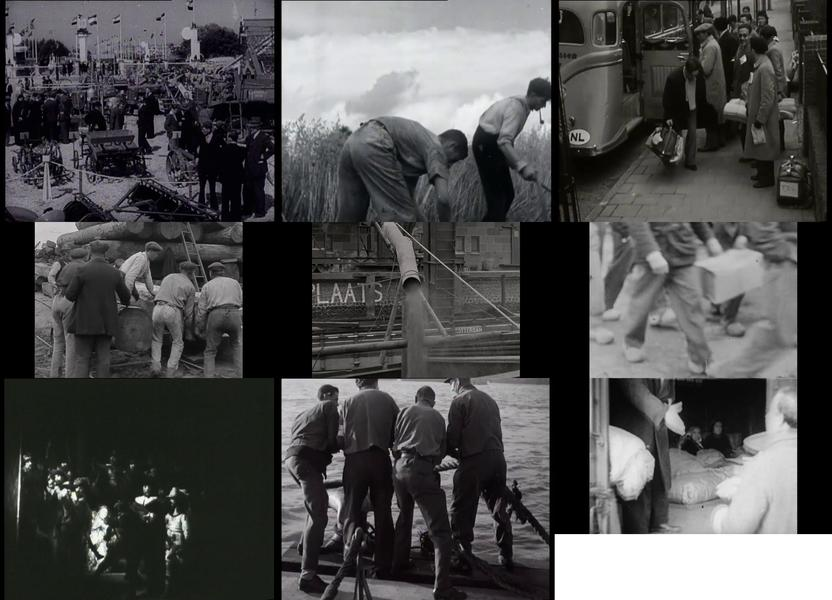
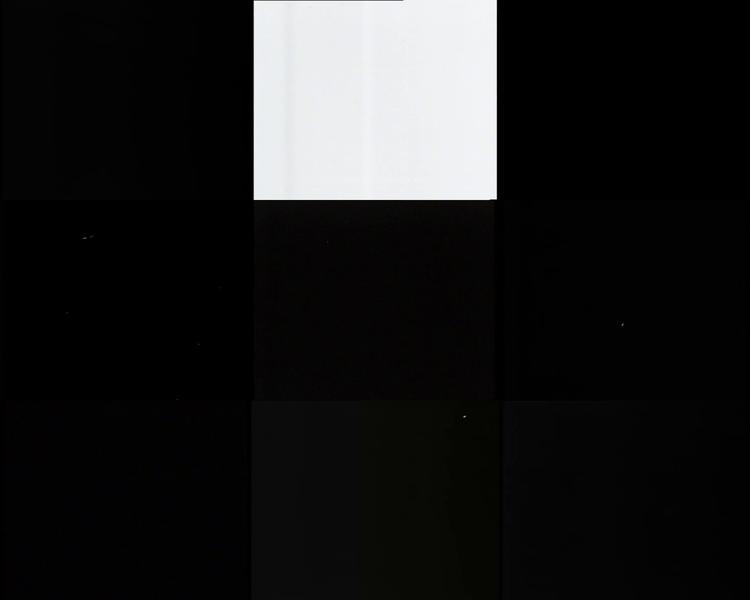

In [8]:
# Ensure directories exist
os.makedirs(DATA_FOLDER, exist_ok=True)

# Load all image paths
image_paths = glob.glob(os.path.join(IMAGE_FOLDER, "*.jpg"))

# Define embedding model for images (CLIP-based)
embedding_model = MultiModalBackend("clip-ViT-B-32", batch_size=32)

# Define image-to-text captioning model
representation_model = {
    "Visual_Aspect": VisualRepresentation(image_to_text_model="nlpconnect/vit-gpt2-image-captioning")
}

# Train BERTopic with images only
topic_model = BERTopic(
    embedding_model=embedding_model, 
    representation_model=representation_model, 
    min_topic_size=5  # Adjust to your dataset size
)

# Fit model on images
topics, probs = topic_model.fit_transform(documents=None, images=image_paths)

# Save results to a DataFrame
df = pd.DataFrame({"Image": image_paths, "Cluster": topics})
df.to_csv(OUTPUT_CSV, index=False)
print(f"Clustering complete. Results saved to {OUTPUT_CSV}")

# Function to display images in Jupyter Notebook
def image_base64(im):
    if isinstance(im, str):
        im = Image.open(im).resize((128, 128))  # Resize for display
    with BytesIO() as buffer:
        im.save(buffer, "jpeg")
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# Extract cluster details and display images
df_clusters = topic_model.get_topic_info().drop(columns=["Representative_Docs", "Name"])
HTML(df_clusters.to_html(formatters={"Visual_Aspect": image_formatter}, escape=False))

In [15]:
# Filter rows where Cluster == 1
df_cluster_1 = df[df["Cluster"] == 1]

# Display the filtered DataFrame
print(df_cluster_1)

# Save to a new CSV file
df_cluster_1.to_csv("../data_info/cluster_1_images.csv", index=False)


                                                Image  Cluster
0   ../extracted_images\2051906_data_euscreenXL_ht...        1
3   ../extracted_images\2051906_data_euscreenXL_ht...        1
5   ../extracted_images\2051906_data_euscreenXL_ht...        1
7   ../extracted_images\2051906_data_euscreenXL_ht...        1
9   ../extracted_images\2051906_data_euscreenXL_ht...        1
22  ../extracted_images\2051906_data_euscreenXL_ht...        1
25  ../extracted_images\2051906_data_euscreenXL_ht...        1
27  ../extracted_images\2051906_data_euscreenXL_ht...        1
31  ../extracted_images\2051906_data_euscreenXL_ht...        1
33  ../extracted_images\2051906_data_euscreenXL_ht...        1
36  ../extracted_images\2051906_data_euscreenXL_ht...        1
38  ../extracted_images\2051906_data_euscreenXL_ht...        1
40  ../extracted_images\2051906_data_euscreenXL_ht...        1
48  ../extracted_images\2051906_data_euscreenXL_ht...        1
52  ../extracted_images\2051906_data_euscreenXL_ht...  

In [16]:
import os

# Filter images that belong to Cluster 1
df_cluster_1 = df[df["Cluster"] == 1]

# Delete each image from the folder
for image_path in df_cluster_1["Image"]:
    if os.path.exists(image_path):  # Check if file exists
        os.remove(image_path)  # Delete the file
        print(f"Deleted: {image_path}")
    else:
        print(f"File not found: {image_path}")

print("All Cluster 1 images deleted successfully! 🚀")


Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_1006101_1.jpg
Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_1006159_1.jpg
Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_10692_1.jpg
Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_1129852_1.jpg
Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_1151721_1.jpg
Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_1192484_1.jpg
Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_1196998_1.jpg
Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_1246596_1.jpg
Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_1252763_1.jpg
Deleted: ../extracted_images\2051906_data_euscreenXL_https___www_openbeelden_nl_media_652616_1.jpg
Del

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

Clustering complete. Results saved to ../data_info\image_clusters.csv


,Topic,Count,Representation,Visual_Aspect
0,-1,6,"[painting, chair, over, sitting, on, of, standing, around, man, structure]",
1,0,35,"[people, in, of, with, crowd, street, standing, is, man, knife]",
2,1,19,"[train, man, in, people, around, food, station, of, standing, is]",
3,2,8,"[large, ship, docked, harbor, with, water, and, boats, walking, it]",

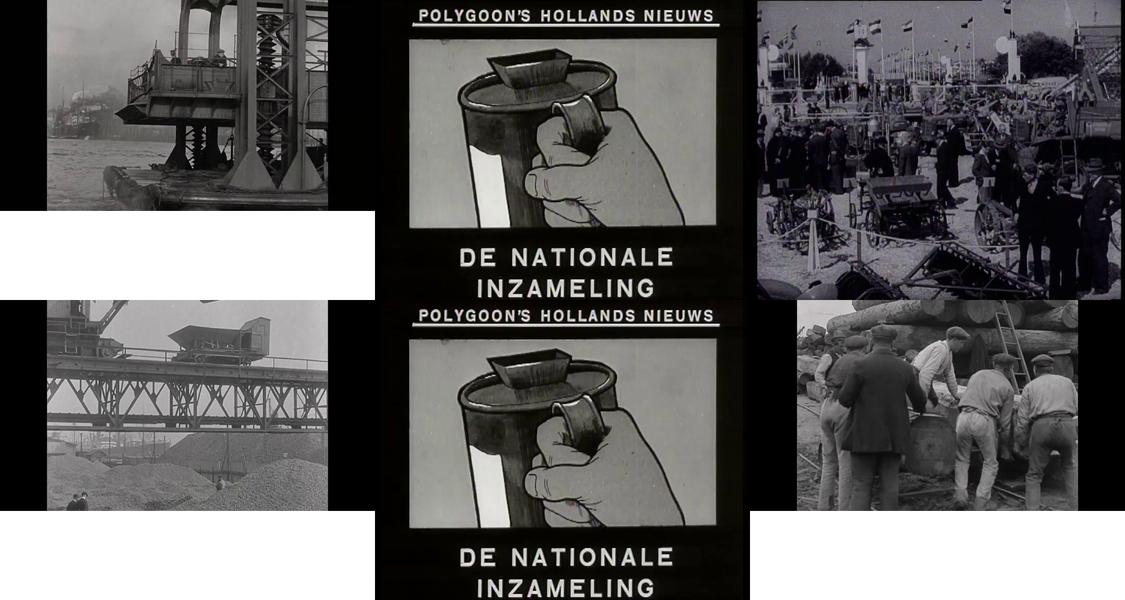
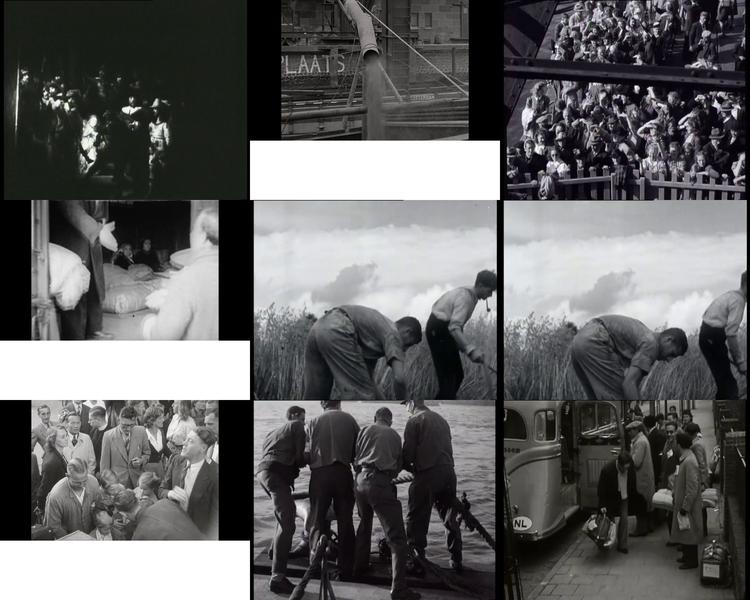
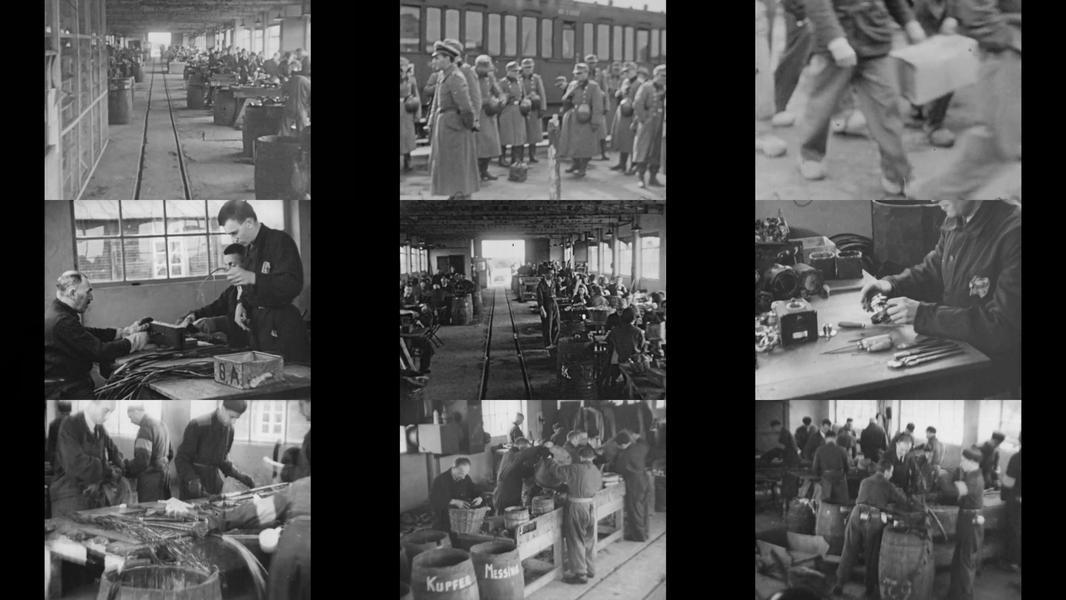
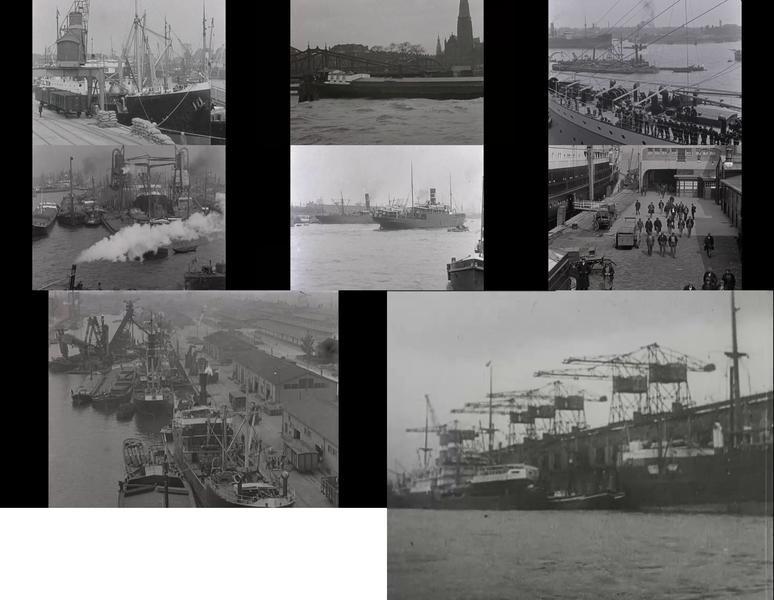

In [17]:
# Ensure directories exist
os.makedirs(DATA_FOLDER, exist_ok=True)

# Load all image paths
image_paths = glob.glob(os.path.join(IMAGE_FOLDER, "*.jpg"))

# Define embedding model for images (CLIP-based)
embedding_model = MultiModalBackend("clip-ViT-B-32", batch_size=32)

# Define image-to-text captioning model
representation_model = {
    "Visual_Aspect": VisualRepresentation(image_to_text_model="nlpconnect/vit-gpt2-image-captioning")
}

# Train BERTopic with images only
topic_model = BERTopic(
    embedding_model=embedding_model, 
    representation_model=representation_model, 
    min_topic_size=5  # Adjust to your dataset size
)

# Fit model on images
topics, probs = topic_model.fit_transform(documents=None, images=image_paths)

# Save results to a DataFrame
df = pd.DataFrame({"Image": image_paths, "Cluster": topics})
df.to_csv(OUTPUT_CSV, index=False)
print(f"Clustering complete. Results saved to {OUTPUT_CSV}")

# Function to display images in Jupyter Notebook
def image_base64(im):
    if isinstance(im, str):
        im = Image.open(im).resize((128, 128))  # Resize for display
    with BytesIO() as buffer:
        im.save(buffer, "jpeg")
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# Extract cluster details and display images
df_clusters = topic_model.get_topic_info().drop(columns=["Representative_Docs", "Name"])
HTML(df_clusters.to_html(formatters={"Visual_Aspect": image_formatter}, escape=False))